## Unit 18 - Use Random Forest on the mini project Time Series

This code is from https://machinelearningmastery.com/random-forest-for-time-series-forecasting/

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [2]:
df = pd.read_csv("IBM_2006-01-01_to_2018-01-01.csv.zip")
df.isnull().values.any()
df = df.dropna()

df.index = pd.to_datetime(df['Date'])
df.head()

,Date,Open,High,Low,Close,Volume,Name
Date,,,,,,,
2006-01-03,2006-01-03,82.45,82.55,80.81,82.06,11715200,IBM
2006-01-04,2006-01-04,82.20,82.50,81.33,81.95,9840600,IBM
2006-01-05,2006-01-05,81.40,82.90,81.00,82.50,7213500,IBM
2006-01-06,2006-01-06,83.95,85.03,83.41,84.95,8197400,IBM
2006-01-09,2006-01-09,84.10,84.25,83.38,83.73,6858200,IBM


In [3]:
# Splitting the train and test set considering 'Open' feature from the dataset
train_data, test_data = df.iloc[0:int(len(df)*0.8), :], df.iloc[int(len(df)*0.8):, :]
train_series = train_data['Open']
test_series = test_data['Open']
train_series.shape, test_series.shape, len(test_data)
# The splitting is done inside the function below

((2415,), (604,), 604)

### Q11: Visualize train and test price data

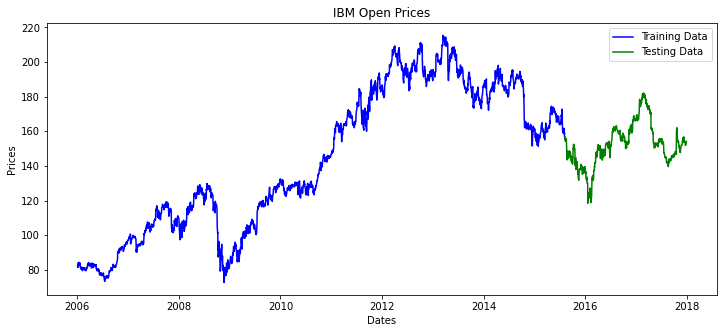

In [4]:
plt.figure(figsize=(12,5))
plt.title('IBM Open Prices')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.plot(train_series, 'blue', label='Training Data')
plt.plot(test_series, 'green', label='Testing Data')
plt.legend();

### Stationary check was done in Mini Project notebook
The data is found to be non-stationary.  However, we are going to try running Random Forest without differencing.

Instead, we will try to use sliding window to perform one step forecast using Random Forest.

In [22]:
# Let's load the libraries and dependencies for the model
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot

In [6]:
# transform a time series dataset into a supervised learning dataset
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols = list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
    # put it all together
    agg = pd.concat(cols, axis=1)
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg.values

# walk-forward validation for univariate data
def walk_forward_validation(data, n_test):
	predictions = list()
	# split dataset
	train, test = train_test_split(data, n_test)
	# seed history with training dataset
	history = [x for x in train]
	# step over each time-step in the test set
	for i in range(len(test)):
		# split test row into input and output columns
		testX, testy = test[i, :-1], test[i, -1]
		# fit model on history and make a prediction
		yhat = random_forest_forecast(history, testX)
		# store forecast in list of predictions
		predictions.append(yhat)
		# add actual observation to history for the next loop
		history.append(test[i])
		# summarize progress
		print('>expected=%.1f, predicted=%.1f' % (testy, yhat))
	# estimate prediction error
	error = mean_absolute_error(test[:, -1], predictions)
    mse = mean_squared_error(test[:, -1], predictions)
	return error, test[:, 1], predictions, mse
# Code from https://machinelearningmastery.com/random-forest-for-time-series-forecasting/

In [7]:
# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
    return data[:-n_test, :], data[-n_test:, :]

# fit an random forest model and make a one step prediction
def random_forest_forecast(train, testX):
	# transform list into array
	train = np.asarray(train)
	# split into input and output columns
	trainX, trainy = train[:, :-1], train[:, -1]
	# fit model
	model = RandomForestRegressor(n_estimators=1000)
	model.fit(trainX, trainy)
	# make a one-step prediction
	yhat = model.predict([testX])
	return yhat[0]

In [13]:
# transform the time series data into supervised learning
values = df[['Open']].values
data = series_to_supervised(values, n_in=1)
data

array([[ 82.45,  82.2 ],
       [ 82.2 ,  81.4 ],
       [ 81.4 ,  83.95],
       ...,
       [152.51, 152.95],
       [152.95, 153.2 ],
       [153.2 , 154.17]])

### Train and Fit and Forecast

In [ ]:
%%time 
# The actual splitting logic is in the function itself.  Here just specify the len(test_data)
# the number of days to predict is the same as the test_data length
predict_length = len(test_data)
print("predict_length=" + str(predict_length))

# Train/Fit/Forecast/Evaluate all inside the function
mae, y, yhat, mse = walk_forward_validation(data, predict_length)

predict_length=604
>expected=155.9, predicted=156.4
>expected=156.8, predicted=153.9
>expected=156.0, predicted=156.3
>expected=154.3, predicted=153.7
>expected=156.1, predicted=154.4
>expected=155.0, predicted=155.8
>expected=155.2, predicted=157.4
>expected=155.5, predicted=156.7
>expected=155.2, predicted=157.9
>expected=152.7, predicted=155.9
>expected=151.5, predicted=152.7
>expected=143.5, predicted=153.7
>expected=146.9, predicted=143.0
>expected=144.1, predicted=148.1
>expected=148.5, predicted=144.5
>expected=147.8, predicted=148.0
>expected=147.4, predicted=148.0
>expected=144.9, predicted=147.3
>expected=144.7, predicted=145.1
>expected=146.1, predicted=144.9
>expected=144.6, predicted=144.7
>expected=145.9, predicted=144.6
>expected=148.7, predicted=145.2
>expected=145.8, predicted=148.2
>expected=145.9, predicted=147.5
>expected=147.4, predicted=145.3
>expected=146.6, predicted=145.8
>expected=147.8, predicted=146.3
>expected=148.1, predicted=147.9
>expected=146.1, predict

In [ ]:
print('MAE: %.3f' % mae)
print('MSE: %.3f' % mse)

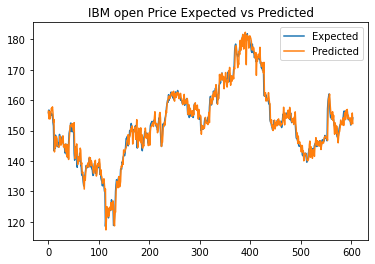

In [16]:
# plot expected vs predicted
pyplot.plot(y, label='Expected')
pyplot.plot(yhat, label='Predicted')
pyplot.legend()
plt.title('IBM open Price Expected vs Predicted')
pyplot.show()

### Visualize only the Test data Price and Predicted Price

In [23]:
# Reconstruct the test data (date) with the predicted price
test_data_p = test_data[['Open']].copy(deep=True)
test_data_p['Expected'] = y
test_data_p['Predicted'] = yhat
test_data_p.head()

,Open,Expected,Predicted
Date,,,
2015-08-07,155.89,155.89,156.400190
2015-08-10,156.77,156.77,153.888650
2015-08-11,155.96,155.96,156.285420
2015-08-12,154.26,154.26,153.815760
2015-08-13,156.06,156.06,154.298974


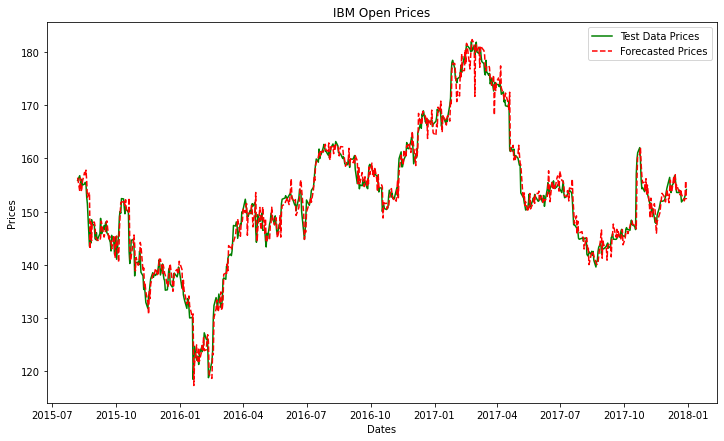

In [20]:
plt.figure(figsize=(12,7))
plt.title('IBM Open Prices')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.plot(test_data_p['Open'], color='green', label='Test Data Prices')
plt.plot(test_data_p['Predicted'], color='red', linestyle='--', label='Forecasted Prices')
plt.legend();

### Scaling
* Is Scaling necessary for Random Forest Time Series model?
* Is Differencing necessary for Random Forest Time Series model?

# Conclusion

Remember we did a rolling point-based prediction for the ARIMA model where we tried to predict every day's (t) stock price in the test data by using both the training data as well as the previous (n - t) days of test data also to fit the model which gave it such good results vs. the LSTM model where we used 2 months of rolling window price data to predict the next day's price.

Here in Random Forest, we are also using a rolling point-based prediction.  Using a sliding window and use the previous data to perform the one step forecast.  It took a long time to perform the forecast iteratively.  The forecast followed the trend closely.